# Authors

Yusuf Olodo and Carlos Cutillas

# Business problem

# Analysis 

## Data importing and cleaning 

In [61]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import random
import scipy.stats as stats
import re

In [2]:
data = pd.read_csv('movies_last.csv')

In [3]:
data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace = True)

In [9]:
# Importing function for data cleaning .py file 
from data_preparing import get_decade

In [7]:
data['all_years'] = data['all_years'].apply(lambda x: re.sub('[^0-9]','', x))

data['all_genres'] = data['all_genres'].apply(lambda x: x[1:])

data['all_gross'] = data['all_gross'].apply(lambda x: x.replace(',',''))
data['all_gross'] = data['all_gross'].apply(lambda x:  int(x) if x != 'no' else 0)

data['all_scores'] = data['all_scores'].apply(lambda x: x.replace('.',''))
data['all_scores'] = data['all_scores'].apply(lambda x: int(x) if x != 'NO' else 0)

data['all_meta'] = data['all_meta'].apply(lambda x: int(x.replace('.','')) if x != 'no' else 0)


data['all_years'] = data['all_years'].apply(lambda x: int(x))

data['dec'] = data['all_years'].apply(lambda x: int(str(x)[2]))
data['decade'] = data['dec'].apply(lambda x: get_decade(x))

In [10]:
del data['dec']

### Importing external csv to get the budget 

In [11]:
movies_metadata = pd.read_csv('movies_metadata.csv')

/Users/carloscutillas/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
budget_and_id = movies_metadata[['budget', 'imdb_id']]

###  Importing external csv to get CPI inflation index 

In [13]:
inflation = pd.read_csv('https://pkgstore.datahub.io/core/cpi-us/cpiai_csv/data/b17bfacbda3c08e51cd13fe544b8fca4/cpiai_csv.csv')

### Cleaning new merges 

In [14]:
inflation['Date'] = inflation['Date'].apply(lambda x: x[:4]) 

inflation['Date'] = inflation['Date'].astype(int)

In [15]:
inf = inflation.groupby('Date').mean().reset_index(level= 0)

### Creating a dataframe with all the data together 

In [16]:
all_data = pd.merge(data, budget_and_id,how='left', left_on='id', right_on='imdb_id')

In [17]:
all_data.dropna(inplace=True)

In [19]:
all_data['budget'] = all_data['budget'].astype(int)
all_data['genre_bis'] = all_data['all_genres'].apply(lambda x: 'Action' if 'Action' in x
                                                     else ('Romance' if 'Romance' in x else 'no') 
                                                    )

In [20]:
all_data['profit'] = all_data['all_gross'] - all_data['budget']

### Merging inflation

In [21]:
data_with_inflation = pd.merge(all_data, inf,how='left', left_on='all_years', right_on='Date')

### Cleaning data with inflation 

In [22]:
del data_with_inflation['Inflation']

In [23]:
from data_preparing import get_last_years_inflation

In [24]:
data_with_inflation['Index_all'] = data_with_inflation['all_years'].apply(lambda x: get_last_years_inflation(x) )
data_with_inflation['Index_all'] = data_with_inflation['Index_all'].astype(str)

data_with_inflation['Index'] = data_with_inflation['Index'].astype(str)


data_with_inflation['Index_all_years'] = data_with_inflation.Index.fillna('') + data_with_inflation.Index_all.fillna('')

# data_with_inflation['Index_all_years'] = data_with_inflation['Index_all'].combine_first(data_with_inflation['Index'])

data_with_inflation['Index_all_years'] = data_with_inflation['Index_all_years'].apply(
    lambda x: x.lstrip('nan').rstrip('nan'))


In [25]:
del data_with_inflation['Index_all']
del data_with_inflation['Index']
del data_with_inflation['Date']


### Adjusting monetary units to inflation 

In [26]:
#  Re converting stringg to integer on index 

data_with_inflation['Index_all_years'] = data_with_inflation['Index_all_years'].astype(float)

In [27]:
data_with_inflation['budget_adjusted'] = (data_with_inflation['budget'] / data_with_inflation['Index_all_years'])*100

data_with_inflation['gross_adjusted'] = (data_with_inflation['all_gross'] / data_with_inflation['Index_all_years'])*100



In [28]:
data_with_inflation['profit_adjusted'] =  data_with_inflation['gross_adjusted'] - data_with_inflation['budget_adjusted'] 

### Exporting to csv (commented out in order to not eport it each time notebook is run)

In [29]:
# data_for_budget = all_data[all_data['budget'] > 0]

In [30]:
# data_for_budget.to_csv('movies_for_budget', encoding='utf-8')
# all_data.to_csv('movies_all', encoding='utf-8')

In [31]:
# data_with_inflation.to_csv('data_adjusted_to_inflation.csv')

## Hypothesis testing 

In [35]:
data_with_inflation = pd.read_csv('data_adjusted_to_inflation.csv')
data_for_ht = data_with_inflation.replace(0,data_with_inflation.median())

### H3 - 50's and 60's movies made more profit than movies nowadays

In [82]:
fifth_movies = list((data_for_ht[(data_for_ht['decade'] == "50s")|(data_for_ht['decade'] == "60s")]['profit_adjusted']))
now_movies = list((data_for_ht[(data_for_ht['decade']== "00s")|(data_for_ht['decade'] == "10s")]['profit_adjusted']))

#### Getting 2 samples of equal size 

In [83]:
fifth_movies_sample = random.sample(fifth_movies, 190)
now_movies_sample = random.sample(now_movies, 190)

#### Variance and mean of the samples 

In [84]:
print("The variance for the movies on 50s/60s is: {}".format(np.var(fifth_movies_sample)))
print("The std for the movies on 50s/60s is: {}".format(np.std(fifth_movies_sample)))
print("The mean for the movies on 50s/60s is: {}".format(np.mean(fifth_movies_sample)))

print('===============')

print("The variance for the movies nowadays is: {}".format(np.var(now_movies_sample)))
print("The std for the movies on nowadays is: {}".format(np.std(now_movies_sample)))
print("The mean for the movies on nowadays is: {}".format(np.mean(now_movies_sample)))



The variance for the movies on 50s/60s is: 6914554065678971.0
The std for the movies on 50s/60s is: 83153797.66239767
The mean for the movies on 50s/60s is: 76760590.45304367
The variance for the movies nowadays is: 532812715466186.75
The std for the movies on nowadays is: 23082736.308033038
The mean for the movies on nowadays is: 9647296.646187529


#### Normality test for samples 

In [85]:
stats.normaltest(now_movies_sample)

NormaltestResult(statistic=56.18421769977186, pvalue=6.305973501700076e-13)

In [86]:
stats.normaltest(fifth_movies_sample)

NormaltestResult(statistic=114.34272647218202, pvalue=1.4818096669386698e-25)

#### Plotting the distribution for both samples

Text(0, 0.5, 'Probability')

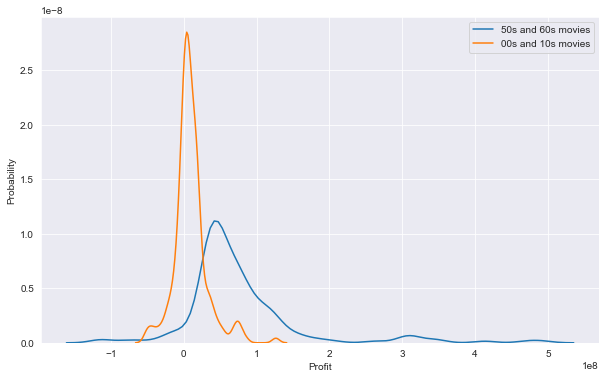

In [87]:
plt.figure(figsize=(10,6))
sns.distplot(fifth_movies_sample, label='50s and 60s movies', hist= False)
sns.distplot(now_movies_sample, label='00s and 10s movies', hist=False)

plt.xlabel('Profit')
plt.ylabel('Probability')

#### Difference between distribution means

In [88]:
diff_means = np.mean(fifth_movies_sample) - np.mean(now_movies_sample)
print("The difference between means is {}".format(diff_means))

The difference between means is 67113293.80685614


#### T-statistic

In [89]:
## Importing function from .py file where we stored them 
from hyp_testing_functions import pooled_variance, tstatistic
from ht_visualizations import visualize_t
 

In [90]:

t_stat = tstatistic(fifth_movies_sample, now_movies_sample)
print("T-Statistic is: {}".format(t_stat))

T-Statistic is: 10.719733351567633


In [91]:
import scipy.stats
# import stats.t
from scipy import stats

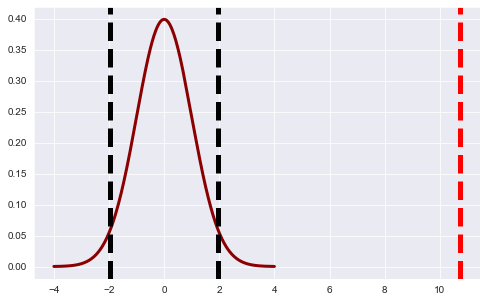

In [92]:

def visualize_t(t_stat, n_control, n_experimental):
    from matplotlib import pyplot as plt 

    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()

    xs = np.linspace(4, -4, 500)

    # use stats.t.ppf to get critical value. For alpha = 0.05 and two tailed test
    crit = stats.t.ppf(1-0.025, (n_control+n_experimental-2))
    
    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(crit, color='black', linestyle='--', lw=5)
    ax.axvline(-crit, color='black', linestyle='--', lw=5)
    ax.axvline(t_stat, color='red', linestyle='--', lw=5)
    
    plt.show()
    return None
n_fifth = len(fifth_movies_sample)
n_now = len(now_movies_sample)
visualize_t(t_stat, n_fifth, n_now)


#### Getting p-value

In [93]:
lower_tail = stats.t.cdf(-t_stat, (190+190-2), 0, 1)
# Upper tail comulative density function returns area under upper tail curve
upper_tail = 1. - stats.t.cdf(t_stat, (190+190-2), 0, 1)

p_value = lower_tail+upper_tail
print(p_value)

6.867799267302472e-24


In [94]:
stats.ttest_ind(fifth_movies_sample, now_movies_sample)

Ttest_indResult(statistic=10.691486310766017, pvalue=1.7357364658161926e-23)

### H4 - Movies nowadays have more budget than in 50s and 60s

In [104]:
fifth_movies = list((data_for_ht[(data_for_ht['decade'] == "50s")|(data_for_ht['decade'] == "60s")]['budget_adjusted']))
now_movies = list((data_for_ht[(data_for_ht['decade']== "00s")|(data_for_ht['decade'] == "10s")]['budget_adjusted']))

#### Getting 2 samples of equal size 

In [105]:
fifth_movies_sample = random.sample(fifth_movies, 190)
now_movies_sample = random.sample(now_movies, 190)

#### Variance and mean of the samples 

In [106]:
print("The variance for the movies on 50s/60s is: {}".format(np.var(fifth_movies_sample)))
print("The std for the movies on 50s/60s is: {}".format(np.std(fifth_movies_sample)))
print("The mean for the movies on 50s/60s is: {}".format(np.mean(fifth_movies_sample)))

print('===============')

print("The variance for the movies nowadays is: {}".format(np.var(now_movies_sample)))
print("The std for the movies on nowadays is: {}".format(np.std(now_movies_sample)))
print("The mean for the movies on nowadays is: {}".format(np.mean(now_movies_sample)))



The variance for the movies on 50s/60s is: 481427044520174.3
The std for the movies on 50s/60s is: 21941445.816540312
The mean for the movies on 50s/60s is: 19805174.756366752
The variance for the movies nowadays is: 549915188906200.7
The std for the movies on nowadays is: 23450270.550810296
The mean for the movies on nowadays is: 25026051.15699739


#### Normality test for samples 

In [107]:
stats.normaltest(now_movies_sample)

NormaltestResult(statistic=81.5288067668812, pvalue=1.9780831909932436e-18)

In [108]:
stats.normaltest(fifth_movies_sample)

NormaltestResult(statistic=168.27091130705898, pvalue=2.8869274984362527e-37)

#### Plotting the distribution for both samples

Text(0, 0.5, 'Probability')

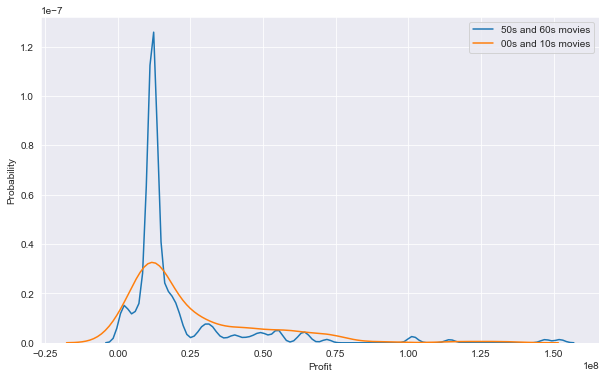

In [109]:
plt.figure(figsize=(10,6))
sns.distplot(fifth_movies_sample, label='50s and 60s movies', hist= False)
sns.distplot(now_movies_sample, label='00s and 10s movies', hist=False)

plt.xlabel('Profit')
plt.ylabel('Probability')

#### Difference between distribution means

In [110]:
diff_means = np.mean(fifth_movies_sample) - np.mean(now_movies_sample)
print("The difference between means is {}".format(diff_means))

The difference between means is -5220876.400630638


#### Welch T-statistic

In [111]:
# importnting welch_t from our .py file
from hyp_testing_functions import welch_t

In [112]:
welch_t_test = welch_t(fifth_movies_sample, now_movies_sample)
print("Welch t-statistic is {}".format(welch_t_test))

Welch t-statistic is 2.234976251118416


#### Visualising Welch T-test

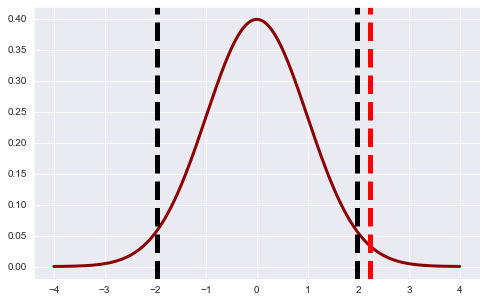

In [113]:
visualize_t(welch_t_test, n_fifth, n_now)

#### Getting the p-value 

In [130]:
# importnting p-value from our .py file
# from hyp_testing_functions import p_value_

In [128]:
## for now we leave it written here 


def p_value_(a, b, two_sided=True):

    t = welch_t(a, b)
    df = welch_df(a, b)
    
    p = 1-stats.t.cdf(np.abs(t), df)
    
    if two_sided:
        return 2*p
    else:
        return p

In [129]:
p_value(fifth_movies_sample, now_movies_sample)

TypeError: 'numpy.float64' object is not callable